## Install necessary packages & imports

In [ ]:
# SHAP
# Install SHAP package
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.5 MB/s eta 0:00:00


In [ ]:
import shap
import pandas as pd
import json
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
# import pygaps as pg
import numpy as np
import sklearn
# import pygaps.modelling as pgm
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import random
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid
from pathlib import Path
# import pymatgen.core
# from pymatgen.core.composition import Composition
# from pymatgen.io.cif import CifParser
# from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
# from pymatgen.core.periodic_table import Element
# from pymatgen.core import Structure
# from omsdetector import MofCollection
from os import path
from google.colab import output
import shutil
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from joblib import dump, load
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
import joblib

## Load datasets

In [ ]:
df_HNOP = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/datasets/df_HNOP.csv')
df_HNOP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          5144 non-null   object 
 1   lcd                           5144 non-null   float64
 2   pld                           5144 non-null   float64
 3   void_fraction                 5144 non-null   float64
 4   surface_area_m2g              5144 non-null   float64
 5   surface_area_m2cm3            5144 non-null   float64
 6   Hydrogen adsorption           5144 non-null   float64
 7   Nitrogen adsorption           5144 non-null   float64
 8   Avg. electronegativity        5144 non-null   float64
 9   Avg. metal ionization energy  5144 non-null   float64
 10  Avg. outer orbital energy     5144 non-null   float64
 11  Electron density              5144 non-null   float64
 12  Metal-oxygen distance         5144 non-null   float64
 13  Avg

In [ ]:
df_CoRE_NH = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/datasets/df_CoRE_NH.csv')
df_CoRE_NH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lcd                           60 non-null     float64
 1   pld                           60 non-null     float64
 2   void_fraction                 60 non-null     float64
 3   surface_area_m2g              60 non-null     float64
 4   surface_area_m2cm3            60 non-null     float64
 5   Nitrogen adsorption           60 non-null     float64
 6   name                          60 non-null     object 
 7   Avg. electronegativity        60 non-null     float64
 8   Avg. metal ionization energy  60 non-null     float64
 9   Avg. outer orbital energy     60 non-null     float64
 10  Electron density              60 non-null     float64
 11  Metal-oxygen distance         60 non-null     float64
 12  Avg. linker num.              60 non-null     float64
 13  OMS den

In [ ]:
df_CoRE_NHs = df_CoRE_NH.sort_values(by = 'Nitrogen adsorption', ascending = False).reset_index().drop(['index'], axis = 1)
df_CoRE_NH_trunc = df_CoRE_NHs[df_CoRE_NHs['Nitrogen adsorption'] < 4500]
df_CoRE_N2cleaned = df_CoRE_NH_trunc.iloc[0:-1, :]
df_CoRE_N2cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 11 to 58
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lcd                           48 non-null     float64
 1   pld                           48 non-null     float64
 2   void_fraction                 48 non-null     float64
 3   surface_area_m2g              48 non-null     float64
 4   surface_area_m2cm3            48 non-null     float64
 5   Nitrogen adsorption           48 non-null     float64
 6   name                          48 non-null     object 
 7   Avg. electronegativity        48 non-null     float64
 8   Avg. metal ionization energy  48 non-null     float64
 9   Avg. outer orbital energy     48 non-null     float64
 10  Electron density              48 non-null     float64
 11  Metal-oxygen distance         48 non-null     float64
 12  Avg. linker num.              48 non-null     float64
 13  OMS de

## Primary data analysis

Ignoring `palette` because no `hue` variable has been assigned.
Ignoring `palette` because no `hue` variable has been assigned.


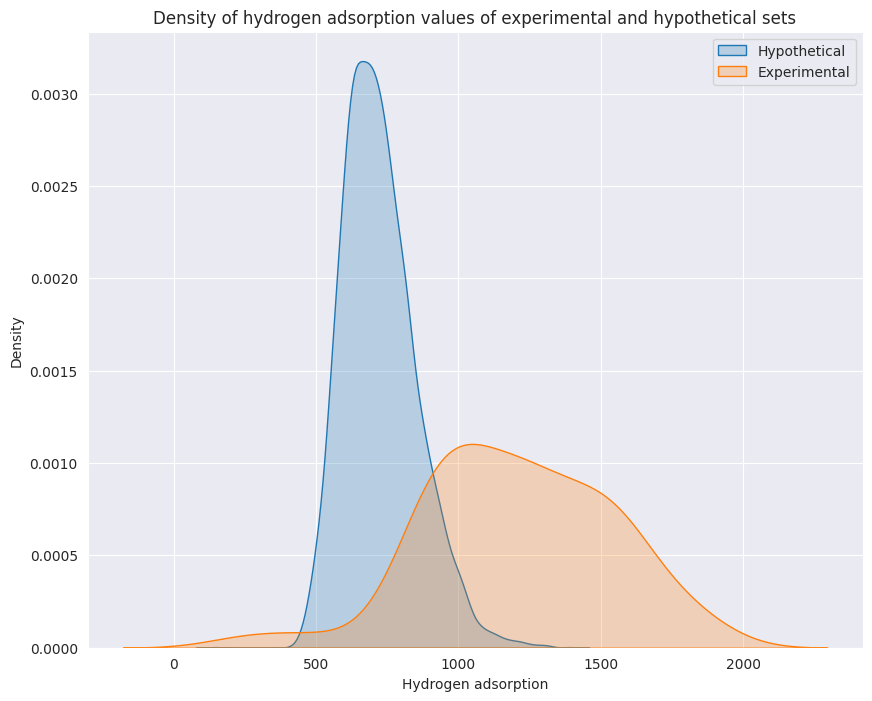

In [ ]:
plt.figure(figsize = (10, 8))
sns.set_style('darkgrid')
sns.kdeplot(data = df_HNOP, x = 'Hydrogen adsorption', fill = True, palette = 'Purples', label = 'Hypothetical')
sns.kdeplot(data = df_CoRE_N2cleaned, x = 'Hydrogen adsorption', fill = True, palette = 'Purples', label = 'Experimental')
plt.legend()
plt.title('Density of hydrogen adsorption values of experimental and hypothetical sets')
# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/dist.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# 23.6.8
# Extract datasets with only the four important parameters
# Normalize all parameters
setn = ['Nitrogen adsorption', 'Electron density', 'Avg. electronegativity', 'void_fraction']

mm = MinMaxScaler()
df_HNOP_pars = pd.DataFrame(mm.fit_transform(df_HNOP.loc[:, setn]), columns = setn)
# df_HNOP_pars.head()
df_CoRE_pars = pd.DataFrame(mm.fit_transform(df_CoRE_N2cleaned.loc[:, setn]), columns = setn)

In [ ]:
df_CoRE_pars.head()
df_HNOP_pars.head()

,Nitrogen adsorption,Electron density,Avg. electronegativity,void_fraction
0,1.000000,0.360880,0.409623,0.702217
1,0.986734,0.369182,0.412536,0.702326
2,0.949041,0.343292,0.246367,0.718444
3,0.795932,0.393524,0.721642,0.711867
4,0.698262,0.340742,0.000000,0.610824


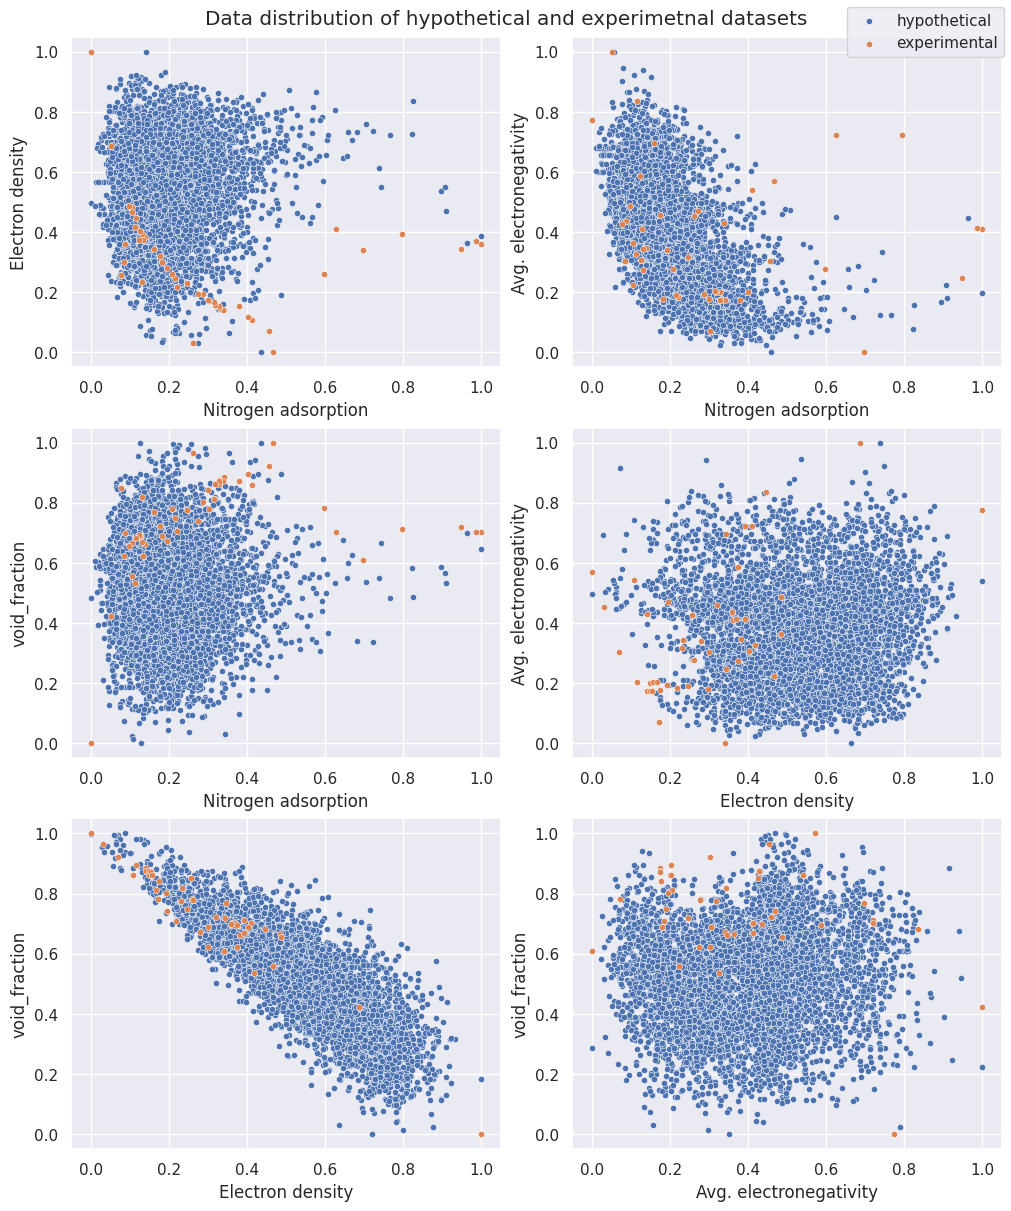

In [ ]:
# Generate comparison graphs
sns.set()
f, ax = plt.subplots(3, 2, figsize = [10, 12], constrained_layout = True)
arr = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
count = 0
i = 0
j = 0

# Loop for constructing the graph
while count < 6:
  p1 = arr[count][0]
  p2 = arr[count][1]
  sns.scatterplot(data = df_HNOP_pars, x = setn[p1], y = setn[p2], ax = ax[j, i], s = 20, label = 'hypothetical')
  sns.scatterplot(data = df_CoRE_pars, x = setn[p1], y = setn[p2], ax = ax[j, i], s = 20, label = 'experimental')
  ax[j, i].get_legend().remove()
  i += 1
  count += 1
  if i == 2:
    i = 0
    j += 1

# Add title
plt.suptitle('Data distribution of hypothetical and experimetnal datasets')

# print(Label)
Line, Label = ax[j - 1, i].get_legend_handles_labels()
f.legend(Line, Label)

# Save figure
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/data_dis.png', dpi = 300, bbox_inches = 'tight')

## Training of TL model

In [ ]:
# Trial training on CoRE set only - with N2 and H2 data
df_CoRE_N2cleaned = df_CoRE_NH_trunc.iloc[0:-1, :]

# Minmax scale dataset
mm = MinMaxScaler()
df_CoRE_N2cleaned = df_CoRE_N2cleaned.reset_index().drop(['index'], axis = 1)
name = df_CoRE_N2cleaned.pop('name')
df_m = pd.DataFrame(mm.fit_transform(df_CoRE_N2cleaned), columns = df_CoRE_N2cleaned.columns)
df_m = pd.concat([name, df_m], axis = 1)

name_HNOP = df_HNOP.pop('name')
df_HNOP_m = pd.DataFrame(mm.fit_transform(df_HNOP), columns = df_HNOP.columns)
df_HNOP_m = pd.concat([name_HNOP, df_HNOP_m], axis = 1)

# Shuffle dataset
df_m = df_m.sample(frac = 1)

df_train = df_m.sample(frac = 0.9, random_state = 0)

ilist = []
for i in range(df_m.shape[0]):
  if i not in df_train.index:
    ilist.append(i)
df_test = df_m.iloc[ilist, :]

# Trial training with RF
X = df_train.drop(['name', 'Hydrogen adsorption', ], axis = 1)
y = df_train['Hydrogen adsorption']

X_test = df_test.drop(['name', 'Hydrogen adsorption', ], axis = 1)
y_test = df_test['Hydrogen adsorption']

X_cv = df_m.drop(['name', 'Hydrogen adsorption', ], axis = 1)
y_cv = df_m['Hydrogen adsorption']

X_TL = df_HNOP_m.drop(['name', 'Hydrogen adsorption', ], axis = 1)
y_TL = df_HNOP_m['Hydrogen adsorption']

In [ ]:
# Training on TL set for reference
RF_TL = RandomForestRegressor(random_state = 0, n_estimators = 104)
RF_TL.fit(X_TL, y_TL)
score = cross_val_score(RF_TL, X_TL, y_TL)
[score, score.mean()]

[array([0.9242971 , 0.92762966, 0.92555816, 0.9093572 , 0.91937939]),
 0.921244302905242]

In [ ]:
r2 = cross_val_score(RF_TL, X_TL, y_TL, cv = 5, scoring = 'r2')
# r2.mean()
MAE = cross_val_score(RF_TL, X_TL, y_TL, cv = 5, scoring = 'neg_mean_absolute_error')
RMSE = cross_val_score(RF_TL, X_TL, y_TL, cv = 5, scoring = 'neg_root_mean_squared_error')

print(f'r2: {r2.mean()}')
print(f'MAE: {-MAE.mean()}')
print(f'MSE: {-RMSE.mean()}')

r2: 0.921244302905242
MAE: 0.02173058451952441
MSE: 0.029154289963636372


In [ ]:
# Build TL dataframe
name = df_HNOP.pop('name')
df_HNOP_m = pd.DataFrame(mm.fit_transform(df_HNOP), columns = df_HNOP.columns)
df_HNOP_m = pd.concat([name, df_HNOP_m], axis = 1)
df_HNOP_m = df_HNOP_m.reset_index().drop(['index'], axis = 1)

In [ ]:
# Ignore warning on first training without adding parameters
warnings.simplefilter('ignore', UserWarning)

# TRIAL: Fit model, change to best configuration later
RF_TL = RandomForestRegressor(random_state = 0, n_estimators = 104, warm_start = True)
RF_TL.fit(X_TL, y_TL)

# Add new trees to prediction
row = []
for i in range(5):
  scorel = []
  RF_TL.fit(X, y)

  score = cross_val_score(RF_TL, X_cv, y_cv)
  scorel.append(score.mean())
  scorel.append(score.std())
  RF_TL.n_estimators += 10

  row.append(scorel)
row

[[0.7633279763099209, 0.15639261456367],
 [0.7610628412186189, 0.16319350847431374],
 [0.7603872900837095, 0.16076631865245009],
 [0.7601668635188047, 0.1643231092945197],
 [0.7591788985286413, 0.16936437566272877]]

In [ ]:
# Comprehensive parameter grid - run this & ignore the following cell for optimization
parameters = {'min_samples_split': range(2, 4),
              'min_samples_leaf': range(1, 3),
              'min_weight_fraction_leaf': [i / 200 for i in range(4)],
              'min_impurity_decrease': [i / 200 for i in range(2)],
              'n_estimators': range(50, 100, 10)}

grid = list(ParameterGrid(parameters))
# grid[0]
len(grid)

160

In [ ]:
# Simplified grid from result
parameters = {'min_samples_split': [2],
              'min_samples_leaf': [2],
              'min_weight_fraction_leaf': [0],
              'min_impurity_decrease': [0],
              'n_estimators': [60]}

grid = list(ParameterGrid(parameters))
# len(grid)

In [ ]:
thres = 0.01

# Initiate dataframe
accl = []

for config in grid:
  # Build grid search
  mid = config['min_impurity_decrease']
  msl = config['min_samples_leaf']
  mss = config['min_samples_split']
  mwfl = config['min_weight_fraction_leaf']
  nest = config['n_estimators']
  RF_TL = RandomForestRegressor(random_state = 0,
                                min_impurity_decrease = mid,
                                min_samples_leaf = msl,
                                min_samples_split = mss,
                                min_weight_fraction_leaf = mwfl,
                                n_estimators = nest,
                                warm_start = True)

# With TL
  # Threshold: increase in training score <0.01
  # Initiate list, first score
  scorel = []
  score = 0
  score_0 = -10

  RF_TL.fit(X_TL, y_TL)

  # Prevent infinite loop
  i = 0
  while score - score_0 >= thres:
    # Start iteration
    score_0 = score
    cvs = cross_val_score(RF_TL, X_cv, y_cv, cv = 5)
    score = cvs.mean()
    std = cvs.std()

    RF_TL.n_estimators += 10
    i += 1
    if i >= 100:
      break

  scorel.append(score)
  scorel.append(std)
  scorel.append(i)
  scorel.append(config)
  accl.append(scorel)

acc = pd.DataFrame(accl, columns = ['score', 'std', 'num_tree_added', 'config'])
acc

,score,std,num_tree_added,config
0,0.811071,0.084915,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
1,0.809547,0.082519,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
2,0.810953,0.077129,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
3,0.807893,0.078331,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
4,0.805621,0.079336,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
...,...,...,...,...
155,0.704575,0.090641,2,"{'min_impurity_decrease': 0.005, 'min_samples_..."
156,0.706035,0.091808,2,"{'min_impurity_decrease': 0.005, 'min_samples_..."
157,0.712355,0.084063,2,"{'min_impurity_decrease': 0.005, 'min_samples_..."
158,0.711372,0.086747,2,"{'min_impurity_decrease': 0.005, 'min_samples_..."


In [ ]:
acc = acc.rename(columns = {'num_tree_added': 'num_tree_added/10'})
best = acc[acc['score'] == acc['score'].max()]
best

,score,std,num_tree_added/10,config
42,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
47,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
52,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
57,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
62,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
67,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
72,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."
77,0.82234,0.046943,2,"{'min_impurity_decrease': 0.0, 'min_samples_le..."


In [ ]:
config = best.config.values[0]
treenum = 10 * best['num_tree_added/10'].iloc[0]
config

{'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 70}

In [ ]:
mid = config['min_impurity_decrease']
msl = config['min_samples_leaf']
mss = config['min_samples_split']
mwfl = config['min_weight_fraction_leaf']
nest = config['n_estimators'] - 10

RF_TL = RandomForestRegressor(random_state = 0,
                              min_impurity_decrease = mid,
                              min_samples_leaf = msl,
                              min_samples_split = mss,
                              min_weight_fraction_leaf = mwfl,
                              n_estimators = nest,
                              warm_start = True)
RF_TL.fit(X_TL, y_TL)

# With TL
RF_TL.n_estimators += treenum
cvs = cross_val_score(RF_TL, X_cv, y_cv, cv = 5)
score = cvs.mean()
std = cvs.std()

[score, std]


# joblib.dump(RF_TL, '/content/drive/MyDrive/Colab_Notebooks/stage_2/RF_best_TL.joblib')

[0.8223402805489712, 0.04694343563268246]

## Generate calibration plots

In [ ]:
# Calculate prediction values
y_TL_pred = RF_TL.predict(X_TL)
y_cv_pred = RF_TL.predict(X_cv)

In [ ]:
# Reference line
ref_line = pd.DataFrame([[0, 0],
                        [1, 1]])
ref_line

,0,1
0,0,0
1,1,1


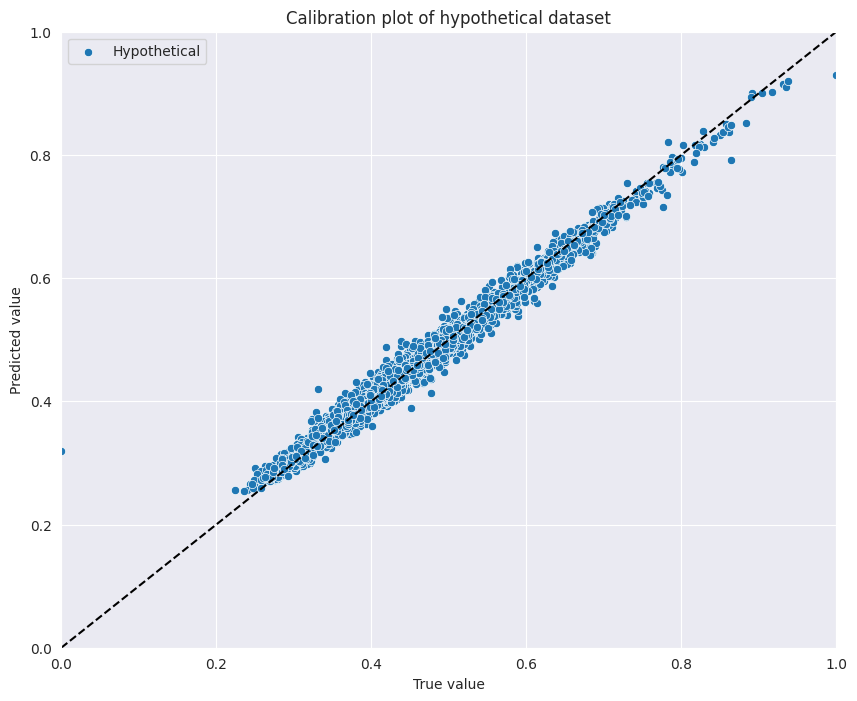

In [ ]:
plt.figure(figsize = (10, 8))
sns.set_style('darkgrid')
sns.scatterplot(x = y_TL, y = y_TL_pred, label = 'Hypothetical')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('True value')
plt.ylabel('Predicted value')
sns.lineplot(data = ref_line, x = 0, y = 1, color = 'black', linestyle = 'dashed')
# sns.kdeplot(data = df_CoRE_N2cleaned, x = 'Hydrogen adsorption', fill = True, palette = 'Purples', label = 'Experimental')
plt.legend()
plt.title('Calibration plot of hypothetical dataset')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/calib_hyp.png', dpi = 300, bbox_inches = 'tight')

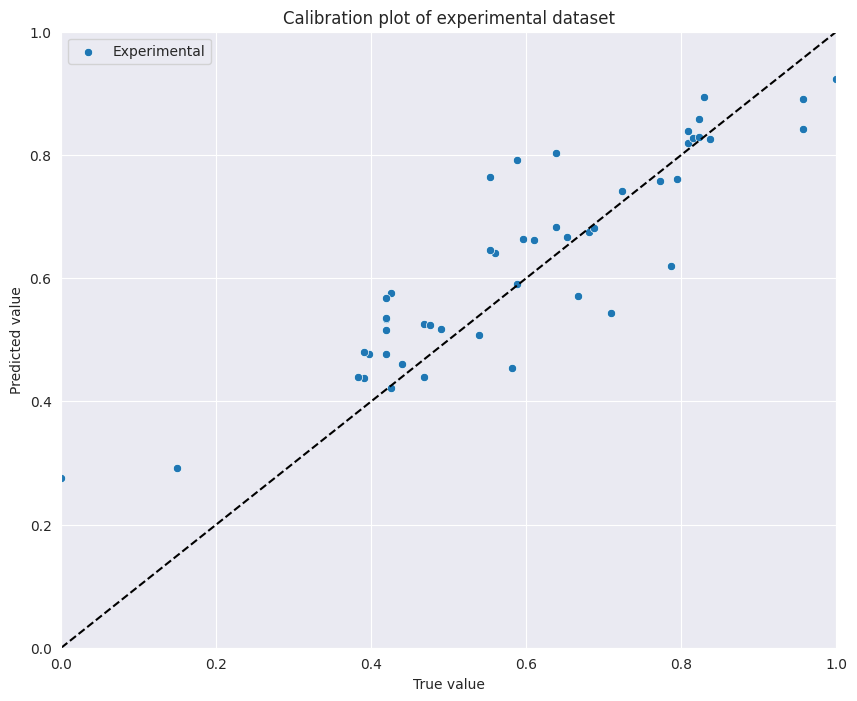

In [ ]:
plt.figure(figsize = (10, 8))
sns.set_style('darkgrid')
sns.scatterplot(x = y_cv, y = y_cv_pred, label = 'Experimental')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('True value')
plt.ylabel('Predicted value')
sns.lineplot(data = ref_line, x = 0, y = 1, color = 'black', linestyle = 'dashed')
# sns.kdeplot(data = df_CoRE_N2cleaned, x = 'Hydrogen adsorption', fill = True, palette = 'Purples', label = 'Experimental')
plt.legend()
plt.title('Calibration plot of experimental dataset')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/calib_exp.png', dpi = 300, bbox_inches = 'tight')

## Explain results with SHAP

In [ ]:
# Create explainer
explainer_TL = shap.TreeExplainer(RF_TL, X_TL)
explainer_cv = shap.TreeExplainer(RF_TL, X_cv)

shap_values_TL = explainer_TL(X_TL)
shap_values_cv = explainer_cv(X_cv)

 99%|===================| 5118/5144 [02:23<00:00]       

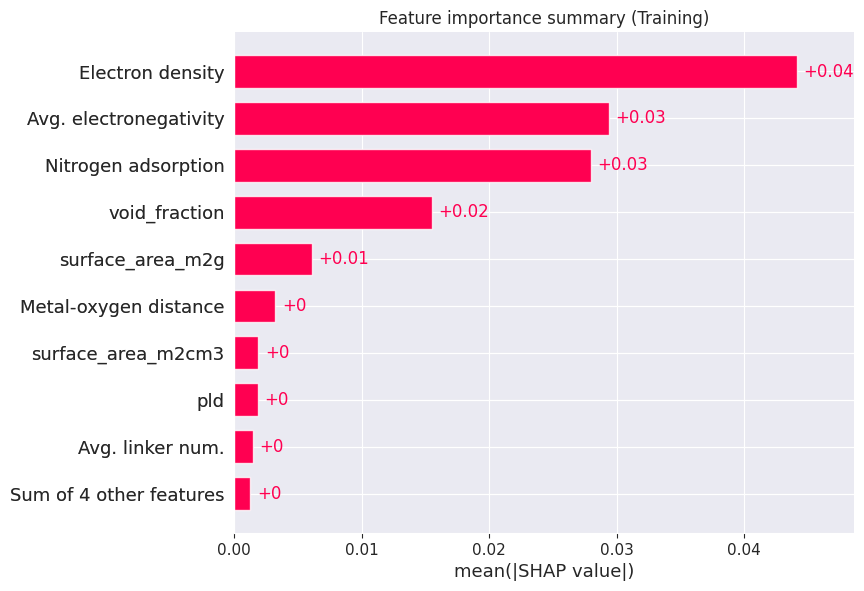

In [ ]:
# Bar plots
# plt.figure(dpi = 150)
plt.title('Feature importance summary (Training)')
sns.set()

shap.plots.bar(shap_values_TL, show = False)
# plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/fimp_sum_TL.png', dpi = 300, bbox_inches = 'tight')

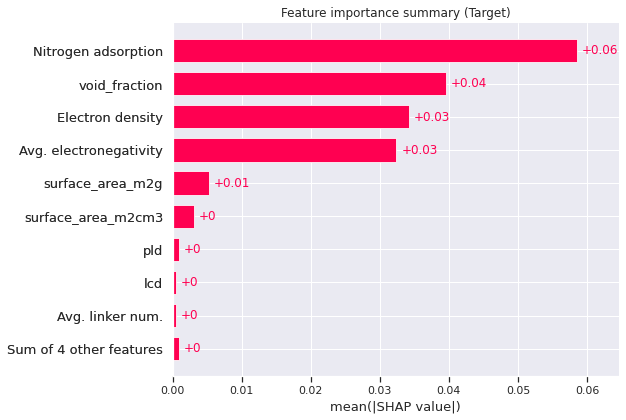

In [ ]:
plt.title('Feature importance summary (Target)')

shap.plots.bar(shap_values_cv, show = False)

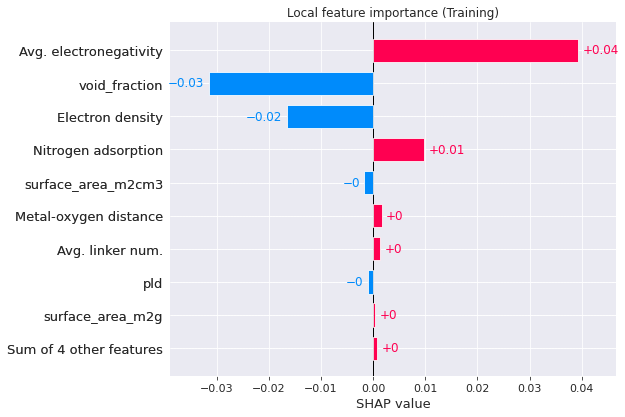

In [ ]:
# Local bar plot
plt.title('Local feature importance (Training)')
sns.set_style('darkgrid')

shap.plots.bar(shap_values_TL[-10], show = False)
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/loc_fimp_TL.png', dpi = 300, bbox_inches = 'tight')

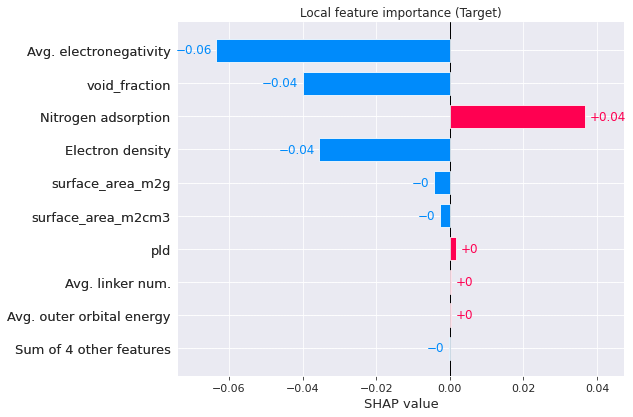

In [ ]:
# Local bar plot
plt.title('Local feature importance (Target)')
sns.set_style('darkgrid')

shap.plots.bar(shap_values_cv[-1], show = False)
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/loc_fimp_cv.png', dpi = 300, bbox_inches = 'tight')

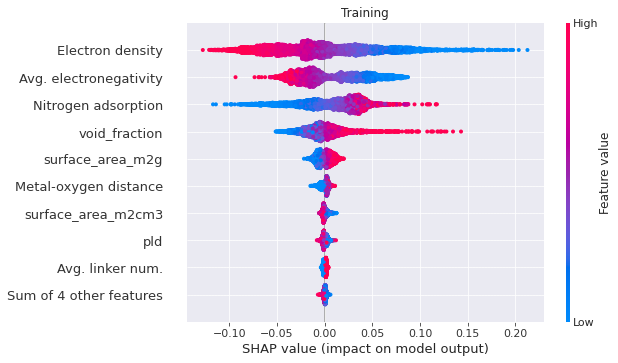

In [ ]:
# Beeswarm polt
sns.set_style('darkgrid')

plt.title('Training')
shap.plots.beeswarm(shap_values_TL, show = False)
# Electron density has negative impact on adsorption.

plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/beeswarm_TL.png', dpi = 300, bbox_inches = 'tight')

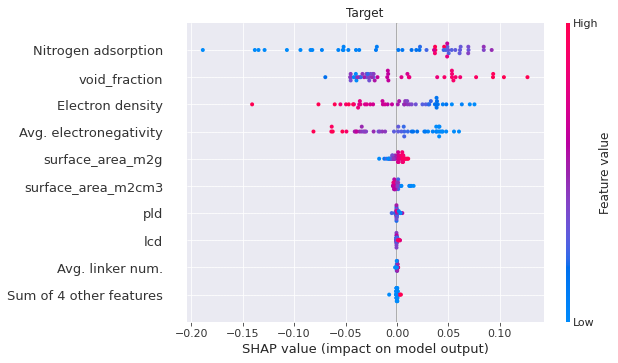

In [ ]:
# Beeswarm polt
sns.set_style('darkgrid')

plt.title('Target')
shap.plots.beeswarm(shap_values_cv, show = False)
# Electron density has negative impact on adsorption.

plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/beeswarm_cv.png', dpi = 300, bbox_inches = 'tight')

In [ ]:
# Setup displayed features
featimp_dict_cv = dict(featname = X_cv.columns, importance = RF_cv.feature_importances_)
featimpt_df_cv = pd.DataFrame(featimp_dict_cv).sort_values(by = 'importance', ascending = False).reset_index()
feats = featimpt_df_cv['featname'][0:20]

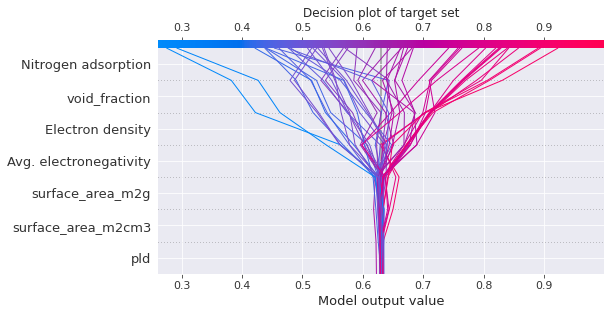

In [ ]:
# Configurations
sns.set_style('darkgrid')
plt.title('Decision plot of target set')

# Plotting
expected_value = explainer_cv.expected_value
shap.decision_plot(expected_value, explainer_cv.shap_values(X_cv), X_cv.columns, feature_display_range = slice(-1, -8, -1), show = False)
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/decision_plot_cv.png', dpi = 300, bbox_inches = 'tight')

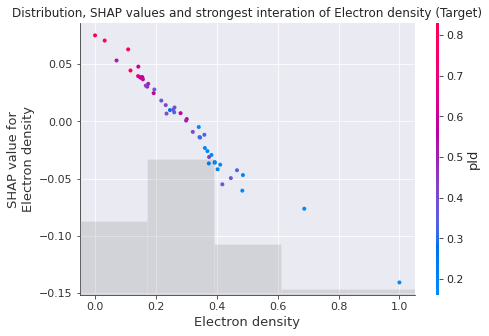

In [ ]:
# Scatter plot of most important features
sns.set_style('darkgrid')

shap.plots.scatter(shap_values_cv[:,"Electron density"], color = shap_values_cv, show = False)
plt.title('Distribution, SHAP values and strongest interation of Electron density (Target)')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/scatter_ed_cv.png', dpi = 300, bbox_inches = 'tight')

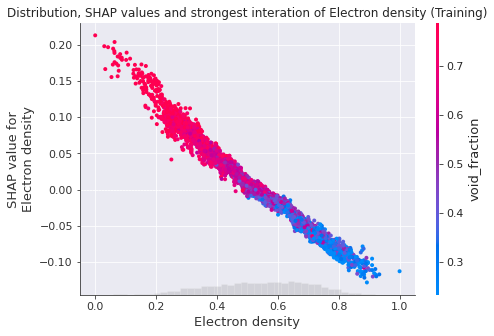

In [ ]:
# Scatter plot of most important features
sns.set_style('darkgrid')

shap.plots.scatter(shap_values_TL[:,"Electron density"], color = shap_values_TL, show = False)
plt.title('Distribution, SHAP values and strongest interation of Electron density (Training)')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/scatter_ed_TL.png', dpi = 300, bbox_inches = 'tight')

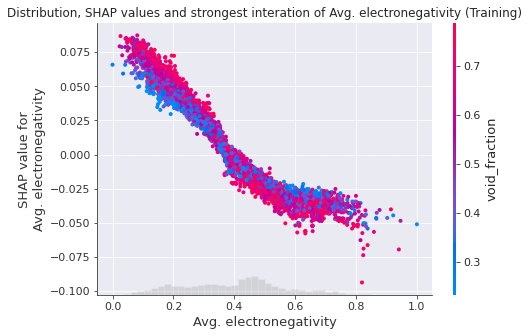

In [ ]:
# Scatter plot of most important features
sns.set_style('darkgrid')

shap.plots.scatter(shap_values_TL[:,"Avg. electronegativity"], color = shap_values_TL, show = False)
plt.title('Distribution, SHAP values and strongest interation of Avg. electronegativity (Training)')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/scatter_avge_TL.png', dpi = 300, bbox_inches = 'tight')

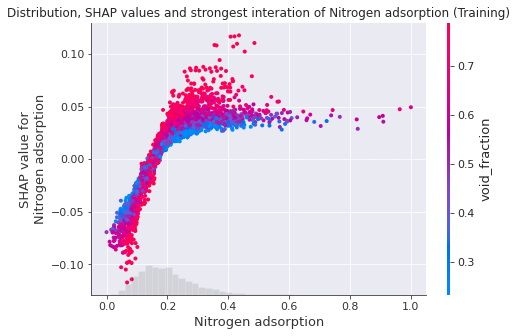

In [ ]:
# Scatter plot of most important features
sns.set_style('darkgrid')

shap.plots.scatter(shap_values_TL[:,"Nitrogen adsorption"], color = shap_values_TL, show = False)
plt.title('Distribution, SHAP values and strongest interation of Nitrogen adsorption (Training)')
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Figures/H2N2TL/N2ads_TL.png', dpi = 300, bbox_inches = 'tight')